In [27]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import pickle as pkl

%run ../../scripts/mfss_model_train.py
%run ../../scripts/coherence_analysis_and_transform.py
%run ../../scripts/utils/data_processing.py
%matplotlib inline

# Load in training and test data

In [6]:
data_path = '../../data/processed/'

In [7]:
# Read in the Hannum dataset for training
hannum = pd.read_pickle(data_path + 'GSE40279_hannum/hannum32.pkl')
hannum_meta = pd.read_excel(data_path + 'GSE40279_hannum/hannum_pmeta.xlsx')

In [8]:
art = np.load(data_path + 'GSE42861_arthritis/arthritis32_full.npy', allow_pickle=True)
art_meta = pd.read_excel(data_path + 'GSE42861_arthritis/arthritis_pmeta.xlsx')
cgs=list_reader(data_path + 'GSE42861_arthritis/cgs_full.txt')
art = pd.DataFrame(art, columns=cgs)

In [9]:
# Read in the Lehne datasat for testing
lehne = np.load(data_path + 'GSE55763_lehne/lehne32_reduced.npy')
lehne_meta = pd.read_excel(data_path + 'GSE55763_lehne/lehne_pmeta.xlsx')
lehne_cgs = list_reader(data_path + 'GSE55763_lehne/cgs')
lehne = pd.DataFrame(lehne, columns=lehne_cgs)

### Read in the filtered (less SNPs and CpGs missing from GSE55763) age correlations 'filtered_age_corrs.xlsx' stored in 'cpg_sets' directory

In [6]:
age_corrs=pd.read_excel(data_path + 'cpg_sets/filtered_age_corrs.xlsx')

In [10]:
age_corrs=pd.read_excel(data_path + 'cpg_sets/hannum_age_corrs.xlsx')

In [11]:
overlap = list(set(lehne.columns) & set(hannum.columns) & set(age_corrs.CpG))

In [12]:
len(overlap)

470767

In [13]:
lehne = lehne[overlap]

In [14]:
hannum = hannum[overlap]

In [16]:
art = art[overlap]

In [17]:
age_corrs = age_corrs[age_corrs.CpG.isin(overlap)]

In [19]:
#Identify arthritis-shifted CpGs
up_shift, down_shift = get_shifts(art, art_meta, age_corrs.CpG[:10000], 'Control')

#Combine
d_shift = pd.concat([up_shift,down_shift])
d_shift.reset_index(inplace=True, drop=True)

In [20]:
#Get correlation magnitudes, sort correlation magnitude (descending)
d_shift['Abs. correlation'] = abs(d_shift.Correlation)
d_shift.sort_values(by='Abs. correlation', ignore_index=True, inplace=True,ascending=False)
d_shift['Abs. d'] = abs(d_shift['Cohens d'])

# Generate Supplementary Table 3

In [44]:
d_shift

,CpG,Shift,Correlation,Cohens d,Sign,Order,Abs. correlation,Abs. d
0,cg16867657,-0.009140,0.847155,0.663105,-1,0,0.847155,0.663105
1,cg21572722,-0.013792,0.745844,1.246969,-1,7,0.745844,1.246969
2,cg22454769,0.009697,0.730099,-0.629524,1,3,0.730099,0.629524
3,cg06639320,-0.007488,0.720896,0.569131,-1,1,0.720896,0.569131
4,cg08097417,-0.007874,0.708310,0.739369,-1,27,0.708310,0.739369
...,...,...,...,...,...,...,...,...
9995,cg16456337,0.011331,0.000061,-1.068008,1,9692,0.000061,1.068008
9996,cg20709868,0.016851,-0.000055,-1.393279,1,9969,0.000055,1.393279
9997,cg16241861,0.011039,0.000055,-0.737081,1,7272,0.000055,0.737081
9998,cg01585758,-0.002377,0.000037,0.499104,-1,5509,0.000037,0.499104


In [21]:
hannum=hannum[d_shift.CpG]

In [22]:
lehne=lehne[d_shift.CpG]
art=art[d_shift.CpG]

In [23]:
#get the transformed data for the training (Hannum), validation (Lehne), and test (arthritis) sets
hannum_transform = coherence_transform(hannum, d_shift)
print('Done')
lehne_transform = coherence_transform(lehne, d_shift)
print('Done')
art_transform = coherence_transform(art, d_shift)

Done
Done


In [31]:
model_cgs, best_iter, val_mse, val_r_val, test_mse, test_r_val = mfss_ols(d_shift.CpG.tolist(), hannum_transform, hannum_meta,
                                                                             lehne_transform, lehne_meta, patience=75,rand_state=3,pos_weights=True)

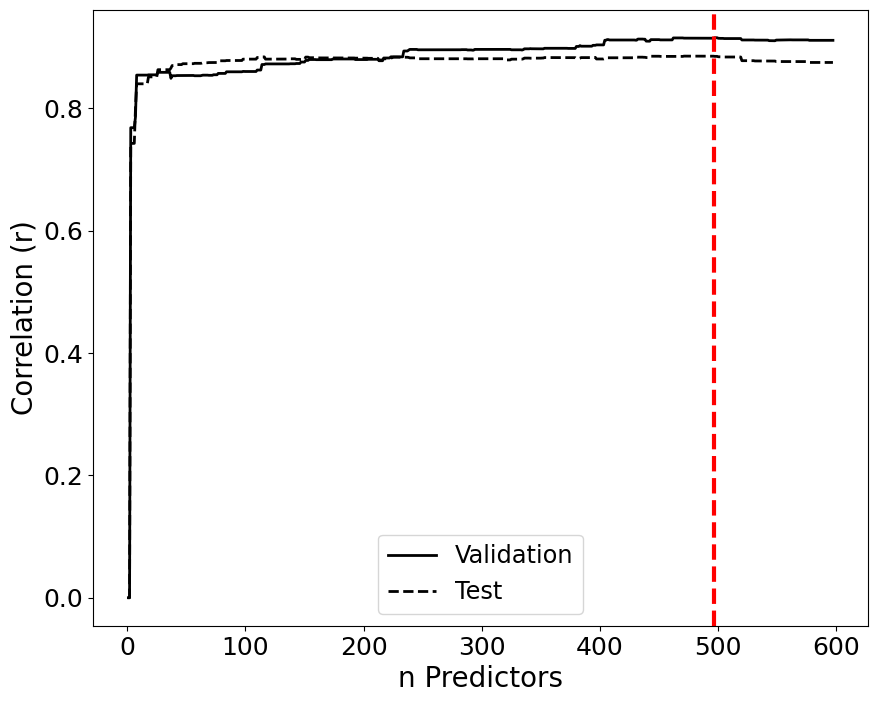

In [32]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_r_val, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_r_val, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20)
plt.ylabel('Correlation (r)',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='best', fontsize='xx-large')

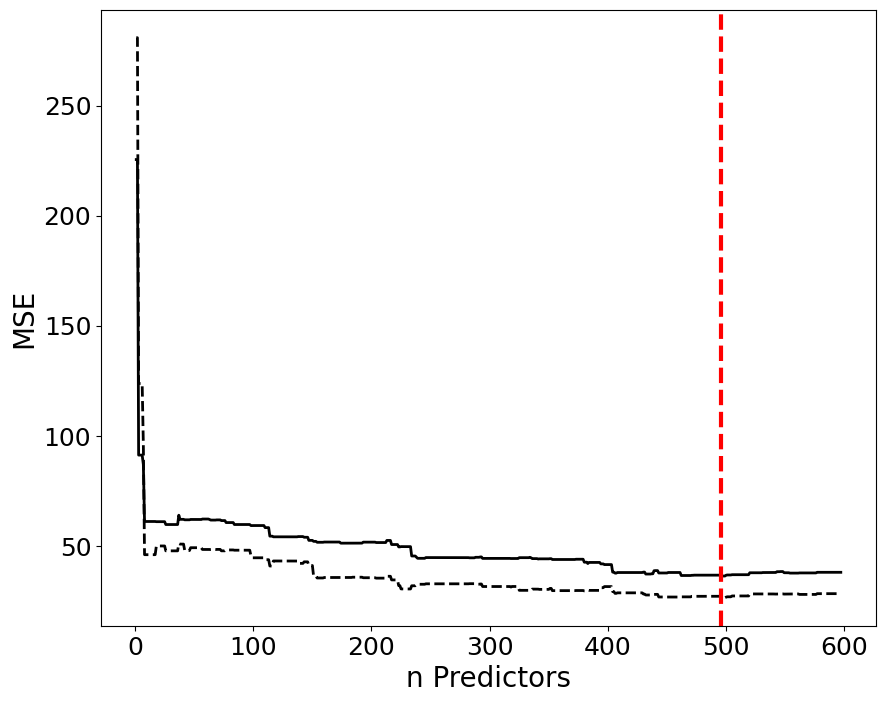

In [33]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_mse, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_mse, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20);
plt.ylabel('MSE',fontsize=20);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

In [58]:
best_iter

227

In [20]:
#Re-sort by disease shift magnitude
d_shift['Abs. shift'] = abs(d_shift.Shift)
d_shift.sort_values(by="Abs. shift", inplace=True,ignore_index=True,ascending=False)

In [29]:
model_cgs, best_iter, val_mse, val_r_val, test_mse, test_r_val = mfss_ols(d_shift.CpG.tolist(), hannum_transform, hannum_meta,
                                                                             lehne_transform, lehne_meta, 800,pos_weights=True)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

Iteration: 558
Iteration: 559
Iteration: 560
Iteration: 561
Iteration: 562
Iteration: 563
Iteration: 564
Iteration: 565
Iteration: 566
Iteration: 567
Iteration: 568
Iteration: 569
Iteration: 570
Iteration: 571
Iteration: 572
Iteration: 573
Iteration: 574
Iteration: 575
Iteration: 576
Iteration: 577
Iteration: 578
Iteration: 579
Iteration: 580
Iteration: 581
Iteration: 582
Iteration: 583
Iteration: 584
Iteration: 585
Iteration: 586
Iteration: 587
Iteration: 588
Iteration: 589
Iteration: 590
Iteration: 591
Iteration: 592
Iteration: 593
Iteration: 594
Iteration: 595
Iteration: 596
Iteration: 597
Iteration: 598
Iteration: 599
Iteration: 600
Iteration: 601
Iteration: 602
Iteration: 603
Iteration: 604
Iteration: 605
Iteration: 606
Iteration: 607
Iteration: 608
Iteration: 609
Iteration: 610
Iteration: 611
Iteration: 612
Iteration: 613
Iteration: 614
Iteration: 615
Iteration: 616
Iteration: 617
Iteration: 618
Iteration: 619
Iteration: 620
Iteration: 621
Iteration: 622
Iteration: 623
Iteration:

Iteration: 1099
Iteration: 1100
Iteration: 1101
Iteration: 1102
Iteration: 1103
Iteration: 1104
Iteration: 1105
Iteration: 1106
Iteration: 1107
Iteration: 1108
Iteration: 1109
Iteration: 1110
Iteration: 1111
Iteration: 1112
Iteration: 1113
Iteration: 1114
Iteration: 1115
Iteration: 1116
Iteration: 1117
Iteration: 1118
Iteration: 1119
Iteration: 1120
Iteration: 1121
Iteration: 1122
Iteration: 1123
Iteration: 1124
Iteration: 1125
Iteration: 1126
Iteration: 1127
Iteration: 1128
Iteration: 1129
Iteration: 1130
Iteration: 1131
Iteration: 1132
Iteration: 1133
Iteration: 1134
Iteration: 1135
Iteration: 1136
Iteration: 1137
Iteration: 1138
Iteration: 1139
Iteration: 1140
Iteration: 1141
Iteration: 1142
Iteration: 1143
Iteration: 1144
Iteration: 1145
Iteration: 1146
Iteration: 1147
Iteration: 1148
Iteration: 1149
Iteration: 1150
Iteration: 1151
Iteration: 1152
Iteration: 1153
Iteration: 1154
Iteration: 1155
Iteration: 1156
Iteration: 1157
Iteration: 1158
Iteration: 1159
Iteration: 1160
Iteratio

Iteration: 1612
Iteration: 1613
Iteration: 1614
Iteration: 1615
Iteration: 1616
Iteration: 1617
Iteration: 1618
Iteration: 1619
Iteration: 1620
Iteration: 1621
Iteration: 1622
Iteration: 1623
Iteration: 1624
Iteration: 1625
Iteration: 1626
Iteration: 1627
Iteration: 1628
Iteration: 1629
Iteration: 1630
Iteration: 1631
Iteration: 1632
Iteration: 1633
Iteration: 1634
Iteration: 1635
Iteration: 1636
Iteration: 1637
Iteration: 1638
Iteration: 1639
Iteration: 1640
Iteration: 1641
Iteration: 1642
Iteration: 1643
Iteration: 1644
Iteration: 1645
Iteration: 1646
Iteration: 1647
Iteration: 1648
Iteration: 1649
Iteration: 1650
Iteration: 1651
Iteration: 1652
Iteration: 1653
Iteration: 1654
Iteration: 1655
Iteration: 1656
Iteration: 1657
Iteration: 1658
Iteration: 1659
Iteration: 1660
Iteration: 1661
Iteration: 1662
Iteration: 1663
Iteration: 1664
Iteration: 1665
Iteration: 1666
Iteration: 1667
Iteration: 1668
Iteration: 1669
Iteration: 1670
Iteration: 1671
Iteration: 1672
Iteration: 1673
Iteratio

Iteration: 2125
Iteration: 2126
Iteration: 2127
Iteration: 2128
Iteration: 2129
Iteration: 2130
Iteration: 2131
Iteration: 2132
Iteration: 2133
Iteration: 2134
Iteration: 2135
Iteration: 2136
Iteration: 2137
Iteration: 2138
Iteration: 2139
Iteration: 2140
Iteration: 2141
Iteration: 2142
Iteration: 2143
Iteration: 2144
Iteration: 2145
Iteration: 2146
Iteration: 2147
Iteration: 2148
Iteration: 2149
Iteration: 2150
Iteration: 2151
Iteration: 2152
Iteration: 2153
Iteration: 2154
Iteration: 2155
Iteration: 2156
Iteration: 2157
Iteration: 2158
Iteration: 2159
Iteration: 2160
Iteration: 2161
Iteration: 2162
Iteration: 2163
Iteration: 2164
Iteration: 2165
Iteration: 2166
Iteration: 2167
Iteration: 2168
Iteration: 2169
Iteration: 2170
Iteration: 2171
Iteration: 2172
Iteration: 2173
Iteration: 2174
Iteration: 2175
Iteration: 2176
Iteration: 2177
Iteration: 2178
Iteration: 2179
Iteration: 2180
Iteration: 2181
Iteration: 2182
Iteration: 2183
Iteration: 2184
Iteration: 2185
Iteration: 2186
Iteratio

# Generate Supplementary Figure 5a (top)

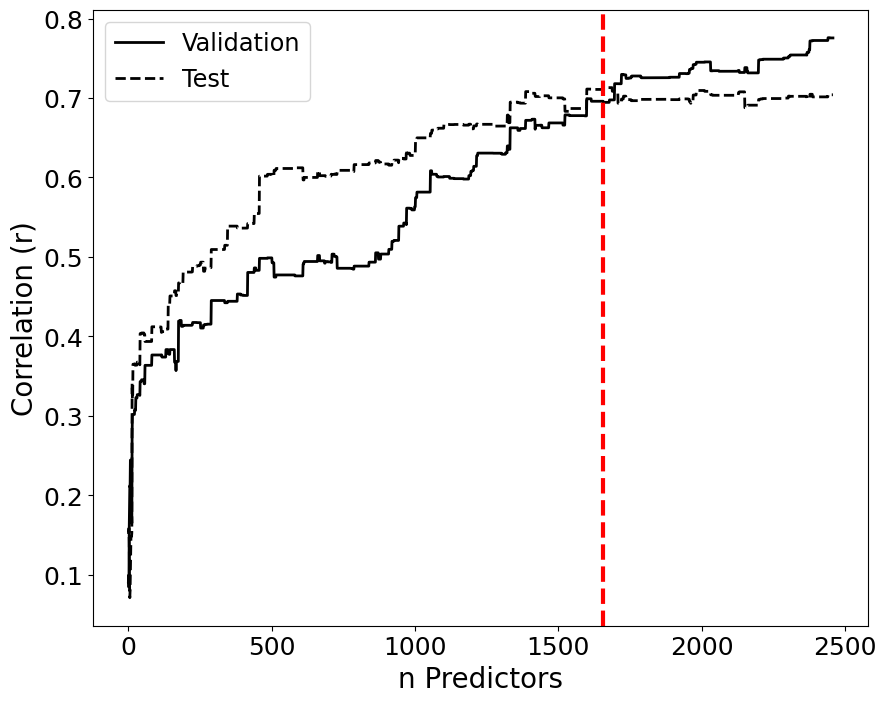

In [30]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_r_val, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_r_val, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20)
plt.ylabel('Correlation (r)',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='best', fontsize='xx-large')

# Generate Supplementary Figure 5a (bottom)

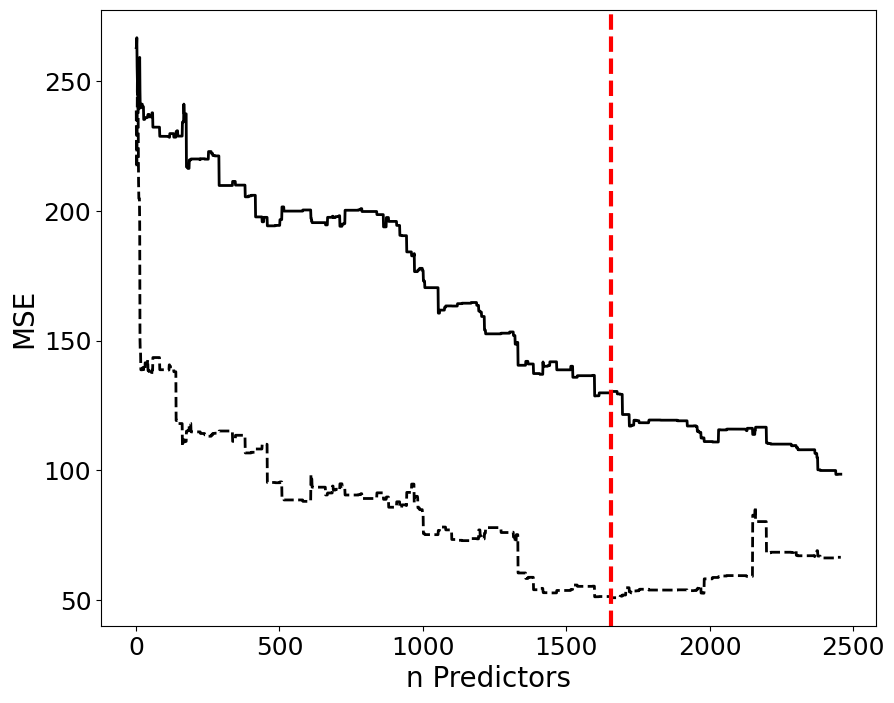

In [31]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_mse, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_mse, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20);
plt.ylabel('MSE',fontsize=20);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

## Load and prep the V7 dataset

In [ ]:
h_comb = np.load('Datasets/Combined/V7_healthy.npy', allow_pickle=True)
d_comb = np.load('Datasets/Combined/V7_disease.npy', allow_pickle=True)
cgs=list_reader('Datasets/Combined/V7_cgs.txt')
h_comb = pd.DataFrame(h_comb, columns=cgs)
d_comb = pd.DataFrame(d_comb, columns=cgs)

v7_meta = pd.read_excel('Datasets/Combined/V7_pmeta.xlsx')
h_meta = v7_meta.copy()
d_meta = v7_meta.copy()
h_meta = h_meta[h_meta.healthy==0]
d_meta = d_meta[d_meta.healthy==1]
h_meta.reset_index(drop=True, inplace=True)
d_meta.reset_index(drop=True, inplace=True)

In [ ]:
#combine into one dataset
v7 = pd.concat([h_comb,d_comb],ignore_index=True)
v7_meta = pd.concat([h_meta,d_meta],ignore_index=True)